In [56]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV ,SGDClassifier
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

In [2]:
print(os.getcwd())
file_path = './datasets/datos_CB.csv'
student_data = pd.read_csv(file_path,index_col=0)
student_data.info()

C:\Users\josec\Documents\FIUNA\9no\IA\datosRendimiento\primerParcial
<class 'pandas.core.frame.DataFrame'>
Int64Index: 97341 entries, 401 to 12388
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ciclo         97341 non-null  int64  
 1   Asignatura    97341 non-null  object 
 2   Convocatoria  97341 non-null  int64  
 3   Anho          97341 non-null  int64  
 4   Aprobado      97341 non-null  int64  
 5   Anho.Firma    97341 non-null  int64  
 6   Primer.Par    97341 non-null  int64  
 7   Segundo.Par   97341 non-null  int64  
 8   AOT           97341 non-null  int64  
 9   Nota.Final    97341 non-null  object 
 10  id_anony      97341 non-null  object 
 11  Nota.Prom     97341 non-null  float64
 12  Firma         97341 non-null  bool   
dtypes: bool(1), float64(1), int64(8), object(3)
memory usage: 9.7+ MB


In [3]:
student_data.head()

,ciclo,Asignatura,Convocatoria,Anho,Aprobado,Anho.Firma,Primer.Par,Segundo.Par,AOT,Nota.Final,id_anony,Nota.Prom,Firma
401,1,CALCULO 3,1,2012,0,0,0,0,0,[0],es_253,0.0,False
402,1,FISICA 4,1,2012,0,2012,19,13,9,[0],es_254,0.0,True
403,1,FISICA 4,1,2012,1,2012,17,24,10,[3],es_255,3.0,True
404,1,FISICA 4,1,2012,0,0,0,0,0,[0],es_256,0.0,False
405,1,FISICA 4,1,2012,0,0,16,12,8,[0],es_257,0.0,False


In [4]:
def get_course(student_data,course):
    condition = student_data["Asignatura"] == course
    course_data = student_data[condition]
    course_data.drop(["Nota.Prom"],axis=1, inplace = True)
    print("\n",len(course_data))
    course_data.head()
    return course_data

In [5]:
course_data = get_course(student_data,'ESTATICA')
course_data.head()


 4824


C:\Users\josec\AppData\Local\Temp\ipykernel_22092\1341986020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  course_data.drop(["Nota.Prom"],axis=1, inplace = True)


,ciclo,Asignatura,Convocatoria,Anho,Aprobado,Anho.Firma,Primer.Par,Segundo.Par,AOT,Nota.Final,id_anony,Firma
1744,2,ESTATICA,1,2012,0,0,2,13,0,[0],es_469,False
1745,2,ESTATICA,1,2012,0,0,6,11,0,[0],es_470,False
1746,2,ESTATICA,1,2012,1,2012,12,24,0,[2],es_175,True
1747,2,ESTATICA,1,2012,0,0,1,1,0,[0],es_910,False
1748,2,ESTATICA,1,2012,0,0,0,0,0,[0],es_1475,False


# Making a new column with number of attemps

In [6]:
def count_attemps(course_data):
    course_data = course_data.sort_values(by=['id_anony','Anho'])
    last_id = course_data['id_anony'].iloc[0]
    counter = 0
    for index,row in course_data.iterrows():
        #print(index)
        if row['id_anony'] == last_id:
            counter += 1 
            course_data.loc[index,['Num.Intento']] = counter
        else:
            last_id = row['id_anony']
            course_data.loc[index,['Num.Intento']] = 1
            counter = 1
    return course_data

In [7]:
course_data = count_attemps(course_data)

# Heat map to check corr

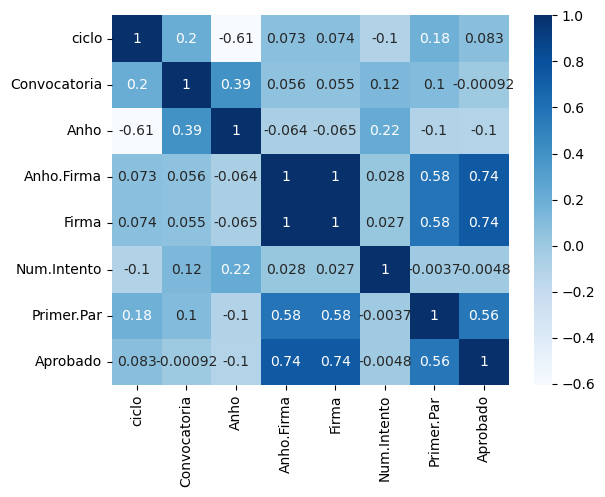

In [8]:
sns.heatmap(course_data[['ciclo','Convocatoria','Anho','Anho.Firma','Firma','Num.Intento','Primer.Par','Aprobado']].corr(), cmap='Blues', annot=True)
plt.show()

# Adding previous course data

In [9]:
def get_previous_course(previous_course):
    #slicing
    formated_title = str.title(previous_course.lower().replace(' ', '_'))
    condition = student_data["Asignatura"] == previous_course
    previous_course_data = student_data[condition]
    previous_course_data = count_attemps(previous_course_data)
    previous_course_data = previous_course_data.rename(columns={'Num.Intento':f'Num.Intento.{formated_title}', 'Nota.Prom' : f'Nota.Prom.{formated_title}'})
    previous_course_data = previous_course_data[["id_anony", f'Nota.Prom.{formated_title}', f'Num.Intento.{formated_title}']]
    
    #grouping by id
    attemps = previous_course_data[['id_anony',f'Num.Intento.{formated_title}']].groupby(['id_anony']).max()
    avg_grade = previous_course_data[['id_anony',f'Nota.Prom.{formated_title}']].groupby(['id_anony']).mean()
    result = pd.concat([avg_grade,attemps],axis=1)
    #result
    
    return result

In [10]:
def merge_previous_course(course_data,result):
    result = pd.merge(course_data, result, on = 'id_anony', how = 'left')
    #for col in result.columns:
    #    print(col,np.unique(result[col]))
    return result


In [11]:
def getNans(result):
    course = result.columns[-1][12:] #get the previous course name
    print("Mean grade with NaN:",np.mean(result.iloc[:,-2]),"Mean attemps with NaN:",np.mean(result.iloc[:,-1]))
    result[f'Nota.Prom.{course}'] = result[f'Nota.Prom.{course}'].fillna(result['Primer.Par']/24*5) #averagin from first midterm
    result[f'Num.Intento.{course}'] = result[f'Num.Intento.{course}'].fillna(np.mean(result[f'Num.Intento.{course}']))
    print('Mean grade interpolated',np.mean(result[f'Nota.Prom.{course}']),'Mean attemps interpolated',np.mean(result[f'Num.Intento.{course}']))


In [12]:
def add_course(course_data,previous_course):
    previous_course_data = get_previous_course(previous_course)
    result = merge_previous_course(course_data,previous_course_data)
    getNans(result)
    original = result.copy()
    y = result['Aprobado']
    result.drop(['ciclo','Asignatura','Aprobado','Segundo.Par','AOT','Anho.Firma','Nota.Final','id_anony'],axis=1,inplace = True)
    return result,y,original

In [13]:
result,y,original = add_course(course_data,'ALGEBRA LINEAL 2')

Mean grade with NaN: 1.9052710303304832 Mean attemps with NaN: 1.7153388822829965
Mean grade interpolated 1.8735312360156886 Mean attemps interpolated 1.7153388822829965


In [14]:
result

,Convocatoria,Anho,Primer.Par,Firma,Num.Intento,Nota.Prom.Algebra_Lineal_2,Num.Intento.Algebra_Lineal_2
0,1,2012,6,False,1.0,1.250000,1.715339
1,1,2013,6,True,1.0,1.250000,1.715339
2,1,2012,15,True,1.0,3.125000,1.715339
3,1,2012,10,True,1.0,2.083333,1.715339
4,1,2013,8,True,3.0,1.666667,1.715339
...,...,...,...,...,...,...,...
4819,1,2012,16,True,1.0,3.333333,1.715339
4820,1,2013,0,False,1.0,0.000000,1.715339
4821,1,2012,3,False,1.0,0.666667,2.000000
4822,1,2013,9,True,2.0,0.666667,2.000000


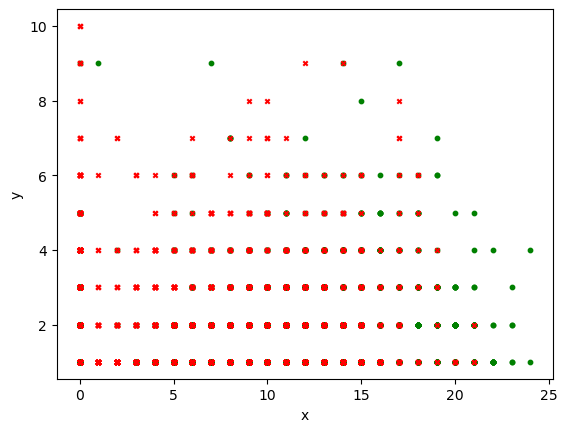

In [258]:
idx_1 = np.where(y == 1)
idx_0 = np.where(y == 0)

plt.scatter(result.iloc[idx_1]["Primer.Par"], result.iloc[idx_1]["Num.Intento"], s=10, c='g', marker="o", label='first')
plt.scatter(result.iloc[idx_0]["Primer.Par"], result.iloc[idx_0]["Num.Intento"], s=10, c='r', marker="x", label='second')
plt.ylabel('y')
plt.xlabel('x')
plt.show()

### Here, it could be useful to repeat this proccess (with a function) and add data for another course like Fisica 1

In [15]:
X_train, X_test, y_train, y_test = train_test_split(result, y, random_state=10)

# Pipeline and Gridsearch

In [16]:
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import learning_curve

from tempfile import mkdtemp
from shutil import rmtree

In [17]:
def hyperparam_search(x,y):
    std_slc = StandardScaler()
    pca = decomposition.PCA()
    logistic_Reg = linear_model.LogisticRegression(solver='liblinear',max_iter=1000)
    cachedir = mkdtemp()

    pipe = Pipeline(steps = [('scaler', StandardScaler()), ('pca', pca), ('logistic_Reg', logistic_Reg)],memory=cachedir)
    n_components = list(range(1,x.shape[1]+1,1))

    C = np.logspace(-4, 4, 100)
    #C = [0.001, 0.01, 0.1, 1, 10, 100]
    penalty = ['l1', 'l2']

    parameters = [
        {'logistic_Reg__solver' : ['liblinear'],
            'pca__n_components' : n_components,
                          'scaler' : [StandardScaler(), MinMaxScaler()],
                          'logistic_Reg__C' : C,
                          'logistic_Reg__penalty' : penalty[0:2]},
        {'logistic_Reg__solver' : ['newton-cg', 'lbfgs','newton-cholesky'],
            'pca__n_components' : n_components,
                          'scaler' : [StandardScaler(), MinMaxScaler()],
                          'logistic_Reg__C' : C,
                          'logistic_Reg__penalty' : penalty[1:]}
                      ]


    clf_GS = GridSearchCV(pipe, parameters, scoring = 'accuracy', n_jobs=-1)
    clf_GS.fit(x, y)
    
    best_parameters = clf_GS.best_estimator_.get_params()
    for param_name in sorted(parameters[0].keys()):
        print(f"{param_name}: {best_parameters[param_name]}")
    print(f"best score: {clf_GS.best_score_}")
    print(clf_GS.best_estimator_.get_params()['logistic_Reg'])
    
    #print('Best scaler:',clf_GS.best_estimator_.get_params()['scaler'])
    #print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
    #print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
    #print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
    #print(clf_GS.best_estimator_.get_params()['logistic_Reg'])

# Without tuning

In [18]:
LR = linear_model.LogisticRegression()
LR.fit(X_train,y_train)
LR.score(X_test,y_test)

C:\Users\josec\anaconda3\envs\IA\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8747927031509121

# With tuning

In [19]:
%store
with warnings.catch_warnings():
    warnings.simplefilter('ignore')    
hyperparam_search(X_train,y_train)

Stored variables and their in-db values:
logistic_Reg__C: 0.002364489412645407
logistic_Reg__penalty: l2
logistic_Reg__solver: liblinear
pca__n_components: 4
scaler: MinMaxScaler()
best score: 0.8656759359024324
LogisticRegression(C=0.002364489412645407, max_iter=1000, solver='liblinear')


# Old parameters attemp

In [20]:
n = 6
scaler = MinMaxScaler()
pca = decomposition.PCA(n_components=n)
logistic_Reg = linear_model.LogisticRegression(C=0.12648552168552957, solver='liblinear', penalty = 'l2')


pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8764510779436152

In [21]:
#without PCA
scaler = StandardScaler()
logistic_Reg = LogisticRegression(C=0.026560877829466867, max_iter=1000, solver='newton-cg')

pipe = Pipeline(steps=[('scaler', scaler), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8756218905472637

# Attemp 1

In [22]:
n = 4
scaler = MinMaxScaler()
pca = decomposition.PCA(n_components=n)
logistic_Reg = linear_model.LogisticRegression(C=0.002364489412645407, max_iter=1000, solver='liblinear')

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8739635157545605

# Confusion matrix for both

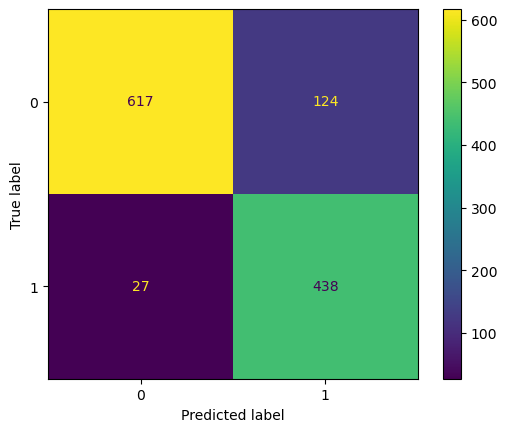

In [23]:
predictions = LR.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

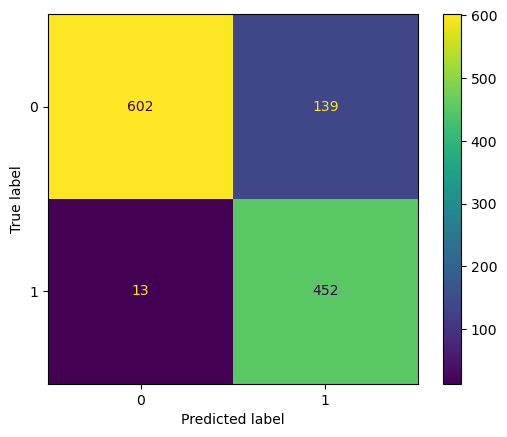

In [24]:
predictions = pipe.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

Maybe changing the threshold could be better

# Learning curve for no tuning and tuned 

Stored variables and their in-db values:


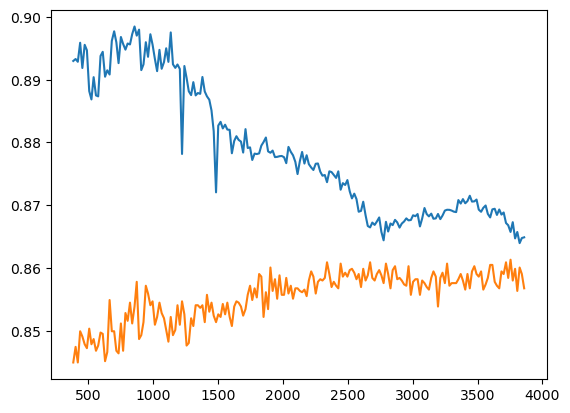

In [25]:
%store
with warnings.catch_warnings():
    warnings.simplefilter('ignore')   
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(LR, result, y, return_times=True, train_sizes=np.linspace(0.1, 1.0, 200))
    plt.plot(train_sizes,np.mean(train_scores,axis=1))
    plt.plot(train_sizes,np.mean(test_scores,axis=1))

Stored variables and their in-db values:


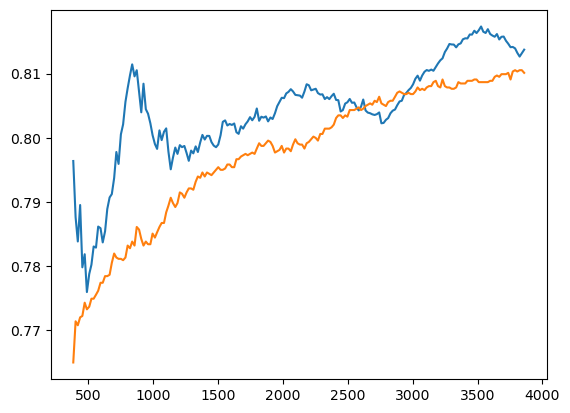

In [26]:
%store
with warnings.catch_warnings():
    warnings.simplefilter('ignore') 
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(logistic_Reg, result, y, return_times=True, train_sizes=np.linspace(0.1, 1.0, 200))
    plt.plot(train_sizes,np.mean(train_scores,axis=1))
    plt.plot(train_sizes,np.mean(test_scores,axis=1))

parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]


# Adding a third course

In [27]:
result,y,original = add_course(original,'FISICA 1')

Mean grade with NaN: 2.791847688610637 Mean attemps with NaN: 1.2760387023335231
Mean grade interpolated 2.501021512806339 Mean attemps interpolated 1.2760387023335231


In [28]:
result

,Convocatoria,Anho,Primer.Par,Firma,Num.Intento,Nota.Prom.Algebra_Lineal_2,Num.Intento.Algebra_Lineal_2,Nota.Prom.Fisica_1,Num.Intento.Fisica_1
0,1,2012,6,False,1.0,1.250000,1.715339,1.250000,1.276039
1,1,2013,6,True,1.0,1.250000,1.715339,1.250000,1.276039
2,1,2012,15,True,1.0,3.125000,1.715339,3.125000,1.276039
3,1,2012,10,True,1.0,2.083333,1.715339,2.083333,1.276039
4,1,2013,8,True,3.0,1.666667,1.715339,1.666667,1.276039
...,...,...,...,...,...,...,...,...,...
4819,1,2012,16,True,1.0,3.333333,1.715339,3.333333,1.276039
4820,1,2013,0,False,1.0,0.000000,1.715339,0.000000,1.276039
4821,1,2012,3,False,1.0,0.666667,2.000000,0.625000,1.276039
4822,1,2013,9,True,2.0,0.666667,2.000000,1.875000,1.276039


In [29]:
X_train, X_test, y_train, y_test = train_test_split(result, y, random_state=10)

%%script false

In [30]:
LR = linear_model.LogisticRegression(max_iter=1000)
LR.fit(X_train,y_train)
LR.score(X_test,y_test)

0.8805970149253731

In [31]:
hyperparam_search(X_train,y_train)

logistic_Reg__C: 4.862601580065354
logistic_Reg__penalty: l1
logistic_Reg__solver: liblinear
pca__n_components: 7
scaler: MinMaxScaler()
best score: 0.8642943383538508
LogisticRegression(C=4.862601580065354, max_iter=1000, penalty='l1',
                   solver='liblinear')


In [32]:
n = 7
scaler = MinMaxScaler()
pca = decomposition.PCA(n_components=n)
logistic_Reg = linear_model.LogisticRegression(C=4.862601580065354, max_iter=1000, penalty='l1',
                   solver='liblinear')

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8797678275290216

# Comparing with a general dataset (without splitting into courses)

In [33]:
student_data
y = student_data['Aprobado']
x = student_data.drop(['Asignatura','Segundo.Par','AOT','Nota.Final','id_anony','Nota.Prom','Aprobado'],axis=1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=10)

In [35]:
hyperparam_search(X_train,y_train)

logistic_Reg__C: 0.20565123083486536
logistic_Reg__penalty: l1
logistic_Reg__solver: liblinear
pca__n_components: 4
scaler: MinMaxScaler()
best score: 0.8474214094925007
LogisticRegression(C=0.20565123083486536, max_iter=1000, penalty='l1',
                   solver='liblinear')


In [36]:
LR = linear_model.LogisticRegression()
LR.fit(X_train,y_train)
LR.score(X_test,y_test)

0.835223537146614

In [37]:
n = 4
scaler = MinMaxScaler()
pca = decomposition.PCA(n_components=n)
logistic_Reg = linear_model.LogisticRegression(C=0.20565123083486536, max_iter=1000, penalty='l1',
                   solver='liblinear')

pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('logistic_Reg', logistic_Reg)])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.847345496383958

# Comparing with XGBoost

In [54]:
from xgboost import XGBClassifier

params = ['binary:logistic','reg:logistic', 'binary:hinge']

for param in params:
    clf_xgb = XGBClassifier(objective = param, seed=10, eval_metric="error")

    result,y,original = add_course(course_data,'ALGEBRA LINEAL 2')

    X_train, X_test, y_train, y_test = train_test_split(result, y, random_state=10)

    pred = clf_xgb.fit(X_train,y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])
    preds_xgb = clf_xgb.predict(X_test)
    accuracy_xgb = float(np.sum(preds_xgb == y_test))/y_test.shape[0]
    print('Accuracy de XGBoost: ', accuracy_xgb)

Mean grade with NaN: 1.9052710303304832 Mean attemps with NaN: 1.7153388822829965
Mean grade interpolated 1.8735312360156886 Mean attemps interpolated 1.7153388822829965
[0]	validation_0-error:0.13184
[1]	validation_0-error:0.11940
[2]	validation_0-error:0.11774
[3]	validation_0-error:0.11857
[4]	validation_0-error:0.12106
[5]	validation_0-error:0.12106
[6]	validation_0-error:0.12272
[7]	validation_0-error:0.12189
[8]	validation_0-error:0.12106
[9]	validation_0-error:0.11609
[10]	validation_0-error:0.11609
[11]	validation_0-error:0.11692
[12]	validation_0-error:0.11692
[13]	validation_0-error:0.12189
[14]	validation_0-error:0.12189
[15]	validation_0-error:0.12272
[16]	validation_0-error:0.12189
[17]	validation_0-error:0.12604
[18]	validation_0-error:0.12355
[19]	validation_0-error:0.12355
Accuracy de XGBoost:  0.8839137645107794


C:\Users\josec\anaconda3\envs\IA\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean grade with NaN: 1.9052710303304832 Mean attemps with NaN: 1.7153388822829965
Mean grade interpolated 1.8735312360156886 Mean attemps interpolated 1.7153388822829965
[0]	validation_0-error:0.13184
[1]	validation_0-error:0.11940
[2]	validation_0-error:0.11774
[3]	validation_0-error:0.11857
[4]	validation_0-error:0.12106
[5]	validation_0-error:0.12106
[6]	validation_0-error:0.12272
[7]	validation_0-error:0.12189
[8]	validation_0-error:0.12106
[9]	validation_0-error:0.11609
[10]	validation_0-error:0.11609
[11]	validation_0-error:0.11692
[12]	validation_0-error:0.11692
[13]	validation_0-error:0.12189
[14]	validation_0-error:0.12189
[15]	validation_0-error:0.12272
[16]	validation_0-error:0.12189
[17]	validation_0-error:0.12604
[18]	validation_0-error:0.12355
Accuracy de XGBoost:  0.8839137645107794


C:\Users\josec\anaconda3\envs\IA\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Mean grade with NaN: 1.9052710303304832 Mean attemps with NaN: 1.7153388822829965
Mean grade interpolated 1.8735312360156886 Mean attemps interpolated 1.7153388822829965
[0]	validation_0-error:0.61443
[1]	validation_0-error:0.12935
[2]	validation_0-error:0.13101
[3]	validation_0-error:0.12852
[4]	validation_0-error:0.12687
[5]	validation_0-error:0.12604
[6]	validation_0-error:0.12604
[7]	validation_0-error:0.12521
[8]	validation_0-error:0.12521
[9]	validation_0-error:0.12521
[10]	validation_0-error:0.12438
[11]	validation_0-error:0.12604
[12]	validation_0-error:0.12687
[13]	validation_0-error:0.12852
[14]	validation_0-error:0.12769
[15]	validation_0-error:0.12935
[16]	validation_0-error:0.13018
[17]	validation_0-error:0.12935
[18]	validation_0-error:0.12769
[19]	validation_0-error:0.12852
Accuracy de XGBoost:  0.8756218905472637


C:\Users\josec\anaconda3\envs\IA\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [50]:
y = student_data['Aprobado']
x = student_data.drop(['Asignatura','Segundo.Par','AOT','Nota.Final','id_anony','Nota.Prom','Aprobado'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=10)
pred = clf_xgb.fit(X_train,y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
preds_xgb = clf_xgb.predict(X_test)
accuracy_xgb = float(np.sum(preds_xgb == y_test))/y_test.shape[0]
print('Accuracy de XGBoost: ', accuracy_xgb)

[0]	validation_0-error:0.13811


C:\Users\josec\anaconda3\envs\IA\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-error:0.13757
[2]	validation_0-error:0.13757
[3]	validation_0-error:0.13774
[4]	validation_0-error:0.13774
[5]	validation_0-error:0.13774
Accuracy de XGBoost:  0.8624260355029586


# XGB trees tuning

Best: 0.839572 using {'n_estimators': 6}
0.829002 (0.021752) with: {'n_estimators': 1}
0.837243 (0.013600) with: {'n_estimators': 2}
0.837972 (0.015697) with: {'n_estimators': 3}
0.839271 (0.018346) with: {'n_estimators': 4}
0.838275 (0.016897) with: {'n_estimators': 5}
0.839572 (0.015554) with: {'n_estimators': 6}
0.838313 (0.016864) with: {'n_estimators': 7}
0.838437 (0.017582) with: {'n_estimators': 8}
0.838401 (0.017933) with: {'n_estimators': 9}
0.836736 (0.017809) with: {'n_estimators': 10}
0.837919 (0.018733) with: {'n_estimators': 11}
0.837907 (0.019546) with: {'n_estimators': 12}
0.837250 (0.019016) with: {'n_estimators': 13}
0.835827 (0.020029) with: {'n_estimators': 14}
0.836031 (0.021428) with: {'n_estimators': 15}
0.833591 (0.019935) with: {'n_estimators': 16}
0.830506 (0.019455) with: {'n_estimators': 17}
0.829980 (0.019582) with: {'n_estimators': 18}
0.829781 (0.019167) with: {'n_estimators': 19}
0.828686 (0.019991) with: {'n_estimators': 20}


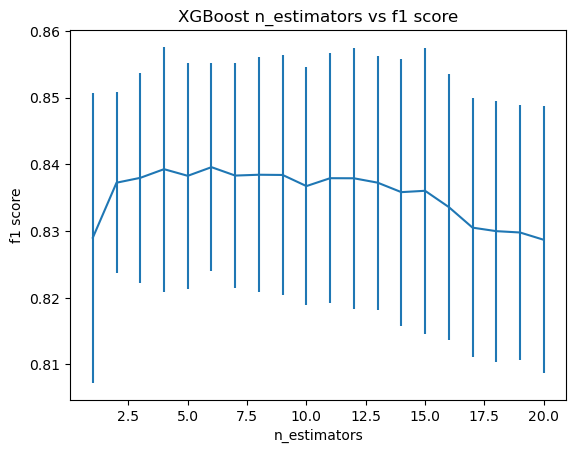

Best: -0.277586 using {'n_estimators': 16}
-0.532851 (0.005855) with: {'n_estimators': 1}
-0.443887 (0.008151) with: {'n_estimators': 2}
-0.389359 (0.011027) with: {'n_estimators': 3}
-0.354110 (0.012876) with: {'n_estimators': 4}
-0.330658 (0.014455) with: {'n_estimators': 5}
-0.314269 (0.015866) with: {'n_estimators': 6}
-0.303356 (0.016754) with: {'n_estimators': 7}
-0.295538 (0.016980) with: {'n_estimators': 8}
-0.289780 (0.017396) with: {'n_estimators': 9}
-0.286442 (0.018111) with: {'n_estimators': 10}
-0.283059 (0.019070) with: {'n_estimators': 11}
-0.280735 (0.019652) with: {'n_estimators': 12}
-0.279646 (0.020108) with: {'n_estimators': 13}
-0.278840 (0.020423) with: {'n_estimators': 14}
-0.277957 (0.021019) with: {'n_estimators': 15}
-0.277586 (0.021652) with: {'n_estimators': 16}
-0.278078 (0.021739) with: {'n_estimators': 17}
-0.278215 (0.021488) with: {'n_estimators': 18}
-0.278321 (0.021674) with: {'n_estimators': 19}
-0.278303 (0.021779) with: {'n_estimators': 20}


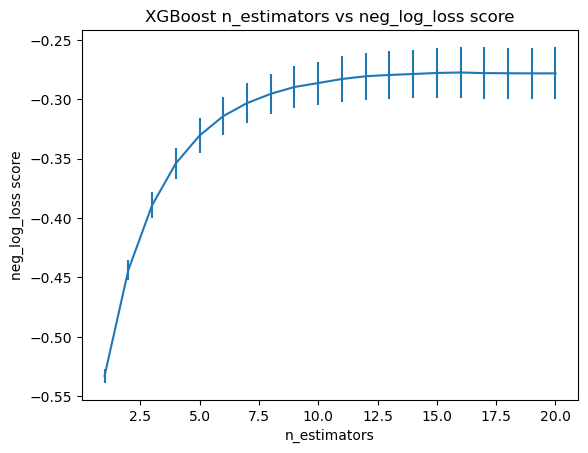

In [119]:
model = XGBClassifier(objective='binary:logistic')
n_estimators = range(1, 21, 1)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
scores = ['f1','neg_log_loss']
for score in scores:
    grid_search = GridSearchCV(model, param_grid, scoring=score, n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
     print("%f (%f) with: %r" % (mean, stdev, param))
    # plot
    plt.errorbar(n_estimators, means, yerr=stds)
    plt.title(f"XGBoost n_estimators vs {score} score")
    plt.xlabel('n_estimators')
    plt.ylabel(f'{score} score')
    plt.savefig('n_estimators.png')
    plt.show()

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: 0.841359 using {'max_depth': 4}, 6 estimators and f1 score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: 0.841634 using {'max_depth': 3}, 7 estimators and f1 score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: 0.842633 using {'max_depth': 3}, 8 estimators and f1 score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: 0.842633 using {'max_depth': 3}, 9 estimators and f1 score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: 0.843637 using {'max_depth': 3}, 10 estimators and f1 score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: 0.842247 using {'max_depth': 2}, 11 estimators and f1 score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: 0.843038 using {'max_depth': 3}, 12 estimators and f1 score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: 0.843017 using {'max_dept

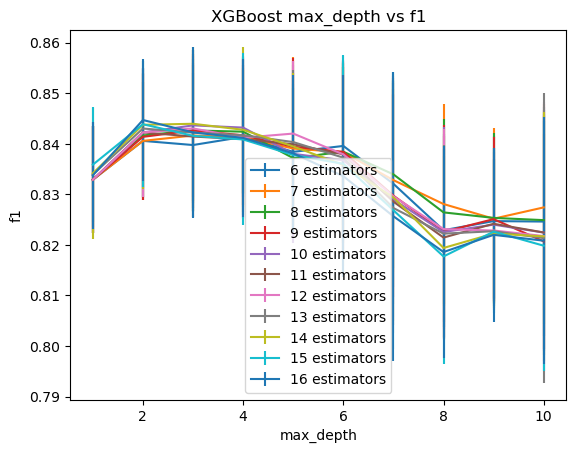

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: -0.314269 using {'max_depth': 6}, 6 estimators and neg_log_loss score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: -0.303356 using {'max_depth': 6}, 7 estimators and neg_log_loss score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: -0.295538 using {'max_depth': 6}, 8 estimators and neg_log_loss score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: -0.289203 using {'max_depth': 4}, 9 estimators and neg_log_loss score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: -0.284605 using {'max_depth': 4}, 10 estimators and neg_log_loss score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: -0.281969 using {'max_depth': 4}, 11 estimators and neg_log_loss score 
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best: -0.279166 using {'max_depth': 4}, 12 estimators and neg_log_loss score 
Fitting 10 folds 

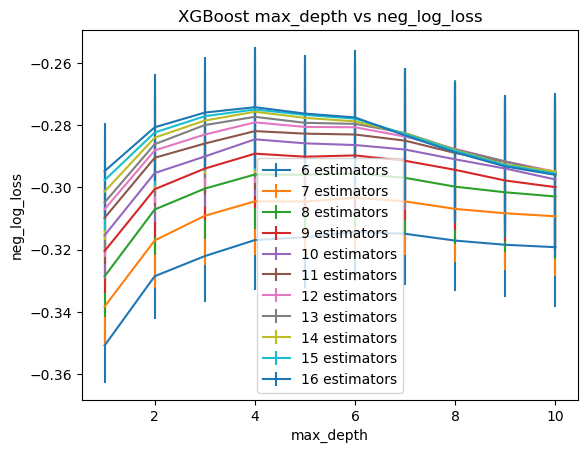

In [120]:
max_depth = range(1, 11, 1)
n_estimators = range(6, 17, 1)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
scores = ['f1','neg_log_loss']
plotted = False
for score,n_estimator in [(score,n_estimator) for score in scores for n_estimator in n_estimators]:
    if score == 'neg_log_loss' and not(plotted):
        plt.show()
        plotted=True
    model = XGBClassifier(objective='binary:logistic',n_estimators=n_estimator)
    grid_search = GridSearchCV(model, param_grid, scoring=score, n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(X_train, y_train)
    # summarize results
    print("Best: %f using %s, %s estimators and %s score " % (grid_result.best_score_, grid_result.best_params_,n_estimator,score))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
     #print("%f (%f) with: %r" % (mean, stdev, param))
    # plot
    plt.errorbar(max_depth, means, yerr=stds, label=f"{n_estimator} estimators")
    plt.title(f"XGBoost max_depth vs {score}")
    plt.xlabel('max_depth')
    plt.ylabel(score)
    leg = plt.legend()
plt.show()

In [183]:
depths = [4,4,3,2]
estimators = [12,10,10,6]
for depth,estimator in zip(depths[:1],estimators[:1]):
    clf_xgb = XGBClassifier(objective = 'binary:logistic',max_depth=depth,n_estimators=estimator, seed=10, eval_metric="error")

    pred = clf_xgb.fit(X_train,y_train, early_stopping_rounds=20, eval_set=[(X_test, y_test)],verbose=False)
    preds_xgb = clf_xgb.predict(X_test)
    accuracy_xgb = float(np.sum(preds_xgb == y_test))/y_test.shape[0]
    print('Accuracy de XGBoost: ', accuracy_xgb)

# 4 12, 4 10, 3 10, 2 6

Accuracy de XGBoost:  0.8830845771144279


In [142]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

def _threshold_finder(model, X, y_true):
    """
    a function to find the optimal threshold for binary classification
    model: a trained model object (such as xgboost, glmnet, ...)
    X: the test set of features (pandas dataframe or numpy array)
    y_true: the true class labels (list or array of 0's and 1's)    
    """
    
    y_predict_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_predict_proba)
    
    class_names = [0, 1]
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    y_pred_youden = (y_predict_proba > youden_threshold).astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred_youden)
    np.set_printoptions(precision=2)
    
    f1 = []
    for i in range(len(precision)):
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))
        
    queue_rate = []
    for thr in thresholds2:
        queue_rate.append((y_predict_proba >= thr).mean()) 

    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.3f}")
    plt.plot(fpr[youden_idx], tpr[youden_idx], marker = "o", color = "navy", ms =10, label =F"Youden Threshold = {youden_threshold:.2f}" )
    plt.axvline(x = fpr[youden_idx], ymin = fpr[youden_idx], ymax = tpr[youden_idx], color = "navy", ls = "--")
    plt.plot([0,1], [0,1] , color = "black", ls = "--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('1 - Specificity' , fontsize=12)
    plt.ylabel('Sensitivity' , fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend( prop={'size':12} , loc = 4)

    plt.subplot(1,2,2)
    _plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, cmap=plt.cm.Reds, title = F"Youden Threshold = {youden_threshold:.2f}\nAccuracy = {accuracy_score(y_true, y_pred_youden)*100:.2f}%")
    plt.show()
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1,2,1)
    plt.plot(thresholds, 1-fpr, label = "1 - Specificity")
    plt.plot(thresholds, tpr, label = "Sensitivity")
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds[np.argmin(abs(tpr + fpr - 1))]+0.2])
    plt.axvline(thresholds[np.argmin(abs(tpr + fpr - 1))], color="k", ls = "--")
    plt.title(F"Threshold = {thresholds[np.argmin(abs(tpr + fpr - 1))]:.3f}", fontsize = 12)
    
    plt.subplot(1,2,2)
    plt.plot(thresholds2, precision[1:], label = "Precision")
    plt.plot(thresholds2, recall[1:], label = "Recall")
    plt.plot(thresholds2, f1[1:], label = "F1-Score")
    plt.plot(thresholds2, queue_rate, label = "Queue Rate")
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds2[np.argmin(abs(precision-recall))] + 0.2])
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.axvline(thresholds2[np.argmin(abs(precision-recall))], color="k", ls = "--")
    plt.title(label = F"Threshold = {thresholds2[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
    plt.show()
    
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True Class', fontsize = 14)
    plt.xlabel('Predicted Class', fontsize = 14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

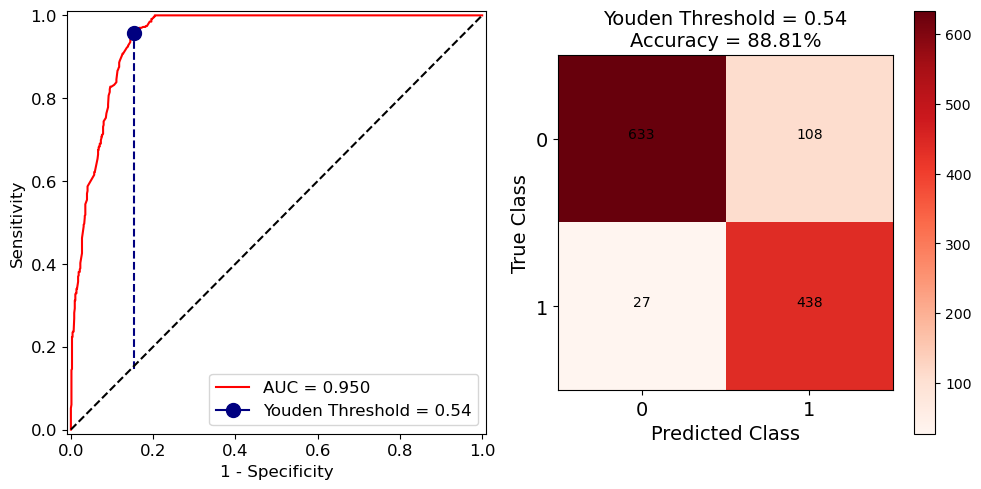

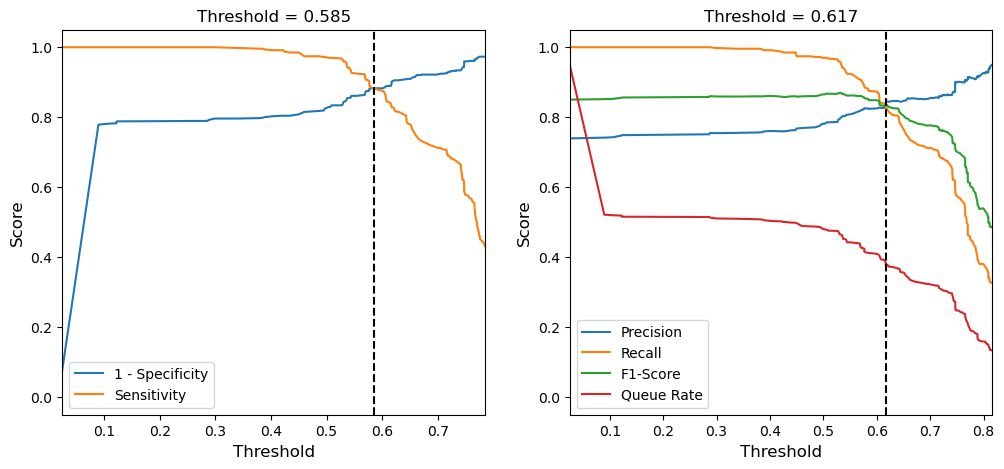

In [184]:
_threshold_finder(model = clf_xgb, X = X_test, y_true = y_test)

In [223]:
clf_xgb = XGBClassifier(objective = 'binary:logistic',max_depth=4,n_estimators=12,seed=10, eval_metric="error@0.54")

thresholds = [0.54, 0.585, 0.617]

pred = clf_xgb.fit(X_train,y_train, early_stopping_rounds=20, eval_set=[(X_test, y_test)])
preds_xgb = clf_xgb.predict(X_test,iteration_range=(0, clf_xgb.best_iteration + 1))
preds_xgb_proba = clf_xgb.predict_proba(X_test,iteration_range=(0, clf_xgb.best_iteration + 1))
#print(preds_xgb)
accuracy_xgb = float(np.sum(preds_xgb == y_test))/y_test.shape[0]

print('Accuracy de XGBoost: ', accuracy_xgb)
print('Error: ', 1-accuracy_xgb)

for threshold in thresholds:
    preds_threshold = (preds_xgb_proba[:,1] >= threshold).astype(int)
    #print(preds_threshold)
    accuracy_xgb = float(np.sum(preds_threshold == y_test))/y_test.shape[0]
    print(f'Accuracy de XGBoost con {threshold} de threshold: ', accuracy_xgb)
    print('Error: ', 1-accuracy_xgb)

[0]	validation_0-error@0.54:0.15755
[1]	validation_0-error@0.54:0.12189
[2]	validation_0-error@0.54:0.12189
[3]	validation_0-error@0.54:0.12106
[4]	validation_0-error@0.54:0.12189
[5]	validation_0-error@0.54:0.12189
[6]	validation_0-error@0.54:0.12189
[7]	validation_0-error@0.54:0.12189
[8]	validation_0-error@0.54:0.11609
[9]	validation_0-error@0.54:0.11443
[10]	validation_0-error@0.54:0.11111
[11]	validation_0-error@0.54:0.11360
Accuracy de XGBoost:  0.8830845771144279
Error:  0.1169154228855721
Accuracy de XGBoost con 0.54 de threshold:  0.8888888888888888
Error:  0.11111111111111116
Accuracy de XGBoost con 0.585 de threshold:  0.8797678275290216
Error:  0.1202321724709784
Accuracy de XGBoost con 0.617 de threshold:  0.8739635157545605
Error:  0.12603648424543945
